# Chapter 6

### USING PRETRAINED WORD EMBEDDINGS

Sometimes, we have so little training data available that we can’t use our data
alone to learn an appropriate task-specific embedding of our vocabulary. What do
we do then?
 
 
Instead of learning word embeddings jointly with the problem we want to solve,
we can load embedding vectors from a precomputed embedding space that we
know is highly structured and exhibits useful properties—that captures generic
aspects of language structure. 

The rationale behind using pretrained word embeddings in natural-language processing is much the same as for using pretrained convnets in image classification: 

* We don’t have enough data available to learn truly
powerful features on our own, but we expect the features that we need to be fairly
generic—that is, common visual features or semantic features. In this case, it makes
sense to reuse features learned on a different problem.

Such word embeddings are generally computed using word-occurrence statistics
(observations about what words co-occur in sentences or documents), using a variety of
techniques, some involving neural networks, others not.

There are various precomputed databases of word embeddings that we can download and use in a **Tensorflow/Keras** Embedding layer. 
* **Word2vec** (https://code.google.com/archive/p/word2vec), is one of them, developed by Tomas Mikolov at Google in 2013. Word2vec dimensions capture specific semantic properties, such as gender.
* Another popular one is called **Global Vectors for Word Representation (GloVe**, https://nlp.stanford
.edu/projects/glove), which was developed by Stanford researchers in 2014. This
embedding technique is based on factorizing a matrix of word co-occurrence statistics. Its developers have made available precomputed embeddings for millions of
English tokens, obtained from Wikipedia data and Common Crawl data.

 Let’s look at how we can get started using **GloVe embeddings** in a Keras model.
The same method is valid for **Word2vec embeddings** or any other word-embedding
database.

We’ll use a model similar to the one we went over: 
* embedding sentences in sequences of vectors, 
* flattening them, and 
* training a Dense layer on top. 

But we’ll do so using pretrained word embeddings; and instead of using the pretokenized IMDB
data packaged in **Tensorflow/Keras**. 

First, head to http://mng.bz/0tIo and download the raw IMDB dataset. Uncompress it.
 
Now, let’s collect the individual training reviews into a list of strings, one string per
review. We’ll also collect the review labels (positive/negative) into a labels list.

In [13]:
# Processing the labels of the raw IMDB data

import os
imdb_dir = 'aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

In [16]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = "utf-8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

### TOKENIZING THE DATA

Let’s vectorize the text and prepare a training and validation split. Because pretrained word embeddings are meant to be particularly useful on problems where little training data is available (otherwise, task-specific embeddings are likely to outperform them). 

We’ll add the following twist:
* Restricting the training data to the first 200 samples. So we’ll learn to classify movie reviews after looking at just 200 examples.

In [18]:
# Tokenizing the text of the raw IMDB data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [19]:
maxlen = 100 # Cuts off reviews after 100 words
training_samples = 200 # Trains on 200 samples
validation_samples = 10000 # Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [20]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [21]:
# Splits the data into a training set and a validation set, but first shuffles the data,
# because we’re starting with data in which samples are ordered (all negative first, then all positive)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [22]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

### DOWNLOADING THE GLOVE WORD EMBEDDINGS

Go to https://nlp.stanford.edu/projects/glove, and download the precomputed
embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called **glove.6B.zip**,
containing 100-dimensional embedding vectors for 400,000 words (or nonword
tokens). Unzip it.

### PREPROCESSING THE EMBEDDINGS

Let’s parse the unzipped file (a `.txt` file) to build an index that maps words (as strings)
to their vector representation (as number vectors).

In [24]:
glove_dir = 'glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding = "utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

In [25]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Next, we’ll build an embedding matrix that we can load into an Embedding layer. It
must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains
the `embedding_dim`-dimensional vector for the word of index `i` in the reference word
index (built during tokenization). Note that index 0 isn’t supposed to stand for any
word or token—it’s a placeholder.

In [27]:
# Preparing the GloVe word-embeddings matrix

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
word_index = tokenizer.word_index

for word, i in word_index.items(): 
    if i < max_words: # 10000 max_words
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [28]:
# Model Building

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


### LOADING THE GLOVE EMBEDDINGS IN THE MODEL

The `Embedding` layer has a single weight matrix: 
* a 2D float matrix 

where each entry `i` is the word vector meant to be associated with index `i`. Simple enough. Load the GloVe matrix we prepared into the `Embedding` layer, the first layer in the model.

Additionally, we’ll freeze the `Embedding` layer (set its `trainable` attribute to `False`),
following the same rationale we’re already familiar with in the context of pretrained
convnet features: 
* When parts of a model are pretrained (like our `Embedding` layer)
and parts are randomly initialized (like our `classifier`), the pretrained parts shouldn’t
be updated during training, to avoid forgetting what they already know. The large gradient updates triggered by the randomly initialized layers would be disruptive to the
already-learned features.

In [29]:
# Loading pretrained word embeddings into the Embedding layer

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [30]:
# Training and evaluation

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 9s 472ms/step - loss: 1.7721 - acc: 0.5016 - val_loss: 0.7017 - val_acc: 0.5000
Epoch 2/10
7/7 [==============================] - 1s 155ms/step - loss: 0.5900 - acc: 0.6190 - val_loss: 0.6866 - val_acc: 0.5497
Epoch 3/10
7/7 [==============================] - 1s 151ms/step - loss: 0.5346 - acc: 0.7866 - val_loss: 0.6864 - val_acc: 0.5397
Epoch 4/10
7/7 [==============================] - 1s 153ms/step - loss: 0.4307 - acc: 0.9163 - val_loss: 0.7342 - val_acc: 0.5075
Epoch 5/10
7/7 [==============================] - 1s 178ms/step - loss: 0.3895 - acc: 0.8747 - val_loss: 0.7655 - val_acc: 0.5128
Epoch 6/10
7/7 [==============================] - 1s 172ms/step - loss: 0.2346 - acc: 0.9872 - val_loss: 0.8841 - val_acc: 0.5083
Epoch 7/10
7/7 [==============================] - 1s 144ms/step - loss: 0.2976 - acc: 0.8642 - val_loss: 0.7469 - val_acc: 0.5430
Epoch 8/10
7/7 [==============================] - 1s 151ms/step - loss: 0.1393 - acc: 1.00

In [31]:
model.save_weights('pre_trained_glove_model.h5')

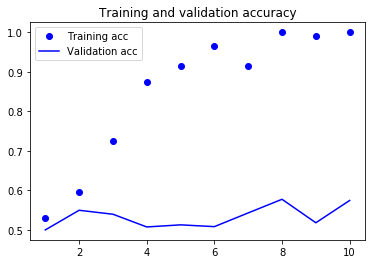

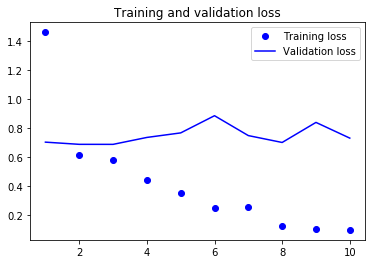

In [32]:
# Plotting the results

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model quickly starts overfitting, which is unsurprising given the small number of
training samples. Validation accuracy has high variance for the same reason, but it
seems to reach the high 50s.
 
Note that our mileage may vary: because we have so few training samples, performance is heavily dependent on exactly which 200 samples we choose—and we’re
choosing them at random. 

If this works poorly for us, try choosing a different random set of 200 samples, for the sake of the exercise (in real life, we don’t get to choose our training data).
 
We can also train the same model without loading the pretrained word embeddings and without freezing the embedding layer. In that case, we’ll learn a taskspecific embedding of the input tokens, which is generally more powerful than
pretrained word embeddings when lots of data is available. But in this case, we have
only 200 training samples.

In [33]:
#  Training the same model without pretrained word embeddings

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(x_train, y_train,epochs=10,batch_size=32,validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 2s 206ms/step - loss: 0.6945 - acc: 0.4676 - val_loss: 0.6909 - val_acc: 0.5305
Epoch 2/10
7/7 [==============================] - 1s 188ms/step - loss: 0.5282 - acc: 0.9643 - val_loss: 0.6906 - val_acc: 0.5318
Epoch 3/10
7/7 [==============================] - 1s 183ms/step - loss: 0.3281 - acc: 0.9874 - val_loss: 0.7058 - val_acc: 0.5284
Epoch 4/10
7/7 [==============================] - 1s 164ms/step - loss: 0.1485 - acc: 1.0000 - val_loss: 0.7009 - val_acc: 0.5387
Epoch 5/10
7/7 [==============================] - 1s 160ms/step - loss: 0.0658 - acc: 1.0000 - val_loss: 0.7154 - val_acc: 0.5399
Epoch 6/10
7/7 [==============================] - 1s 161ms/step - loss: 0.0324 - acc: 1.0000 - val_loss: 0.7191 - val_acc: 0.5464
Epoch 7/10
7/7 [==============================] - 1s 162ms/step - loss: 0.0180 - acc: 1.0000 - val_loss: 0.7331 - val_acc: 0.5446
Epoch 8/10
7/7 [==============================] - 1s 176ms/step - loss: 0.0104 - acc: 1.00

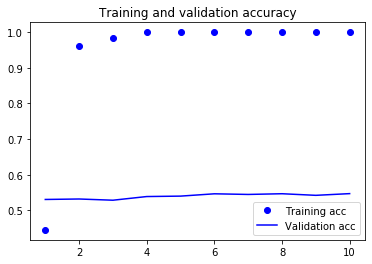

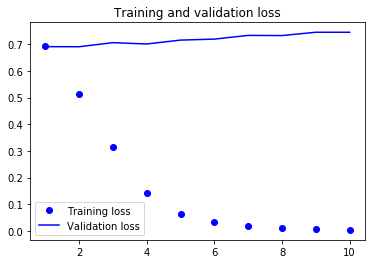

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Validation accuracy stalls in the low 50s. So in this case, pretrained word embeddings
outperform jointly learned embeddings. 

If we increase the number of training samples, this will quickly stop being the case—try it as an exercise.
 
Finally, let’s evaluate the model on the test data. First, we need to tokenize the test
data.

In [37]:
# Tokenizing the data of the test set

test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding = "utf-8")
            texts.append(f.read())
            f.close()
            
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)


In [38]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [39]:
# Evaluating the model on the test set

model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.7414 - acc: 0.5631A: 0s - loss: 0.7422 - acc: 


[0.7413554191589355, 0.5630800127983093]

We get an appalling test accuracy of `56%`. Working with just a handful of training
samples is difficult!

### Conclusion

Now we’re able to do the following:

* Turn raw text into something a neural network can process
* Use the Embedding layer in a Keras model to learn task-specific token embeddings
* Use pretrained word embeddings to get an extra boost on small natural language-processing problems